#### This notebook explores predictions and correlations of freezing behavior
* updated on 6/3/2023 to use the sleep codebase and all the mice

In [1]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd /content/sleep/
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 221 (delta 113), reused 148 (delta 53), pack-reused 0
Receiving objects: 100% (221/221), 1.07 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/sleep
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.1-py3-none-any.whl size=997 sha256=2ce408704b810b7ee44e445226ca0018b95150df988df80fe1ca38e8096e9e78
  Stored in directory: /tmp/pip-ephem-wheel-cache-9shwy887/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [1]:
from pathlib import Path
import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('talk', font_scale=0.6)
import pandas as pd

from datetime import datetime
%matplotlib inline

from sleep.base import core
from sleep.base import xcorr

In [2]:
core.mount_drive()
dr = core.GoogleDrive()
save_dir = Path('/gdrive/Shareddrives/Turi_lab/Data/PTSD_project/' \
                '!analysis/saveFolder/noELS')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
raw_data = dr.load_spreadsheet_data('all_cohorts_freezing_FINAL')
# 'all_cohorts_data_4_27_22', sheet='all_cohorts_data_4_27_22'
raw_data.replace('NA', np.NaN, inplace=True)
raw_data['cohort_id']= raw_data['cohort']+'_'+raw_data['id']
raw_data['cohort_id'] = raw_data['cohort_id'].astype('string')
raw_data['freezing'] = pd.to_numeric(raw_data['freezing'])
df = raw_data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 1 to 1585
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   freezing           1580 non-null   float64
 1   genotype           1585 non-null   object 
 2   id                 1585 non-null   object 
 3   day                1585 non-null   object 
 4   condition          1585 non-null   object 
 5   sex                1585 non-null   object 
 6   cohort             1585 non-null   object 
 7   exposure_mins      1580 non-null   object 
 8   analyzed_duration  1580 non-null   object 
 9   date               1516 non-null   object 
 10  time               1516 non-null   object 
 11  els                1585 non-null   object 
 12  psilocybin         1585 non-null   object 
 13  cohort_id          1585 non-null   string 
dtypes: float64(1), object(12), string(1)
memory usage: 173.5+ KB


In [5]:
# slect non els mice
mice = df[df['els']=='n']
cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6','ptsd8', 'ptsd9',
               'ptsd10', 'els1', 'els2', 'ptsd12', 'ptsd13', 'ptsd14',
               'ptsd15']
# cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6', 'ptsd9', 'els1']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']
mice_df = mice[(mice['cohort'].isin(cohort_list)) & 
                              (mice['day'].isin(day_list))]

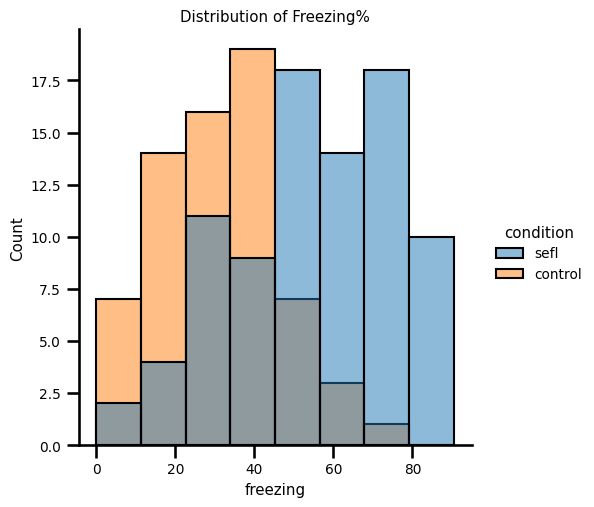

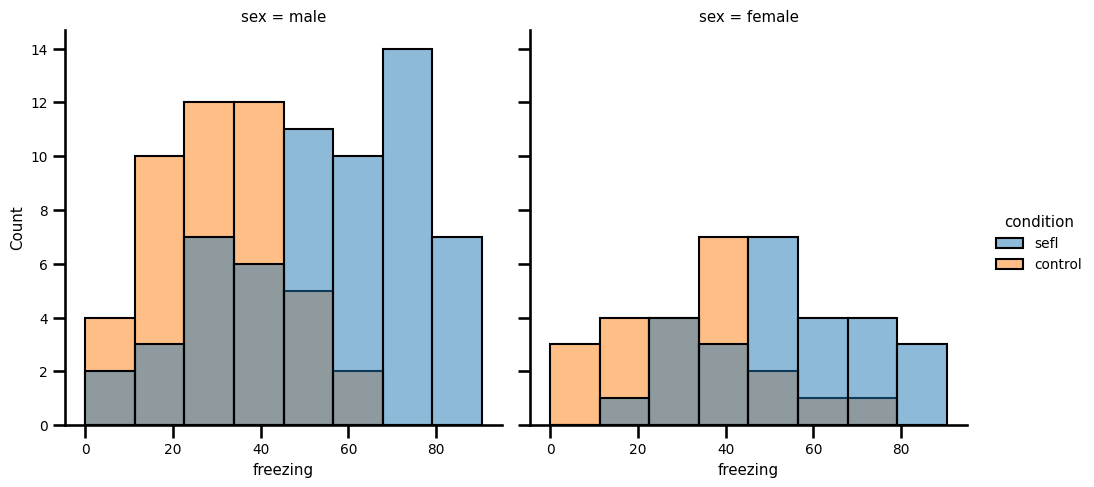

In [6]:
recall1 = mice_df[mice_df['day']== 'recall1']
recall1
d = sns.displot(recall1, x="freezing", hue="condition", bins=8)
d.set(title='Distribution of Freezing%')
d2 = sns.displot(recall1, x="freezing", col="sex",
                 hue="condition", bins=8)

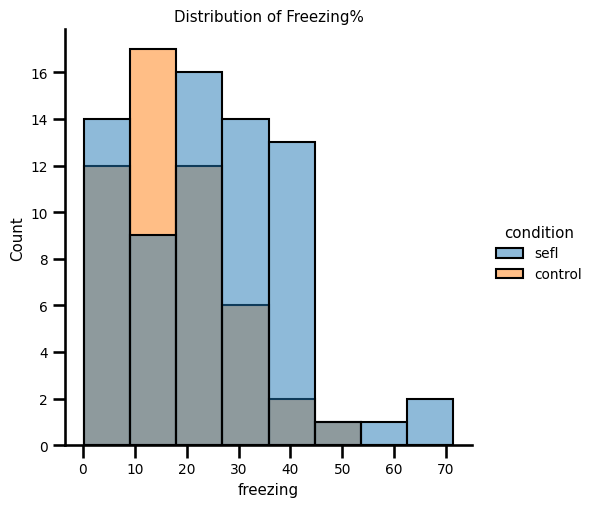

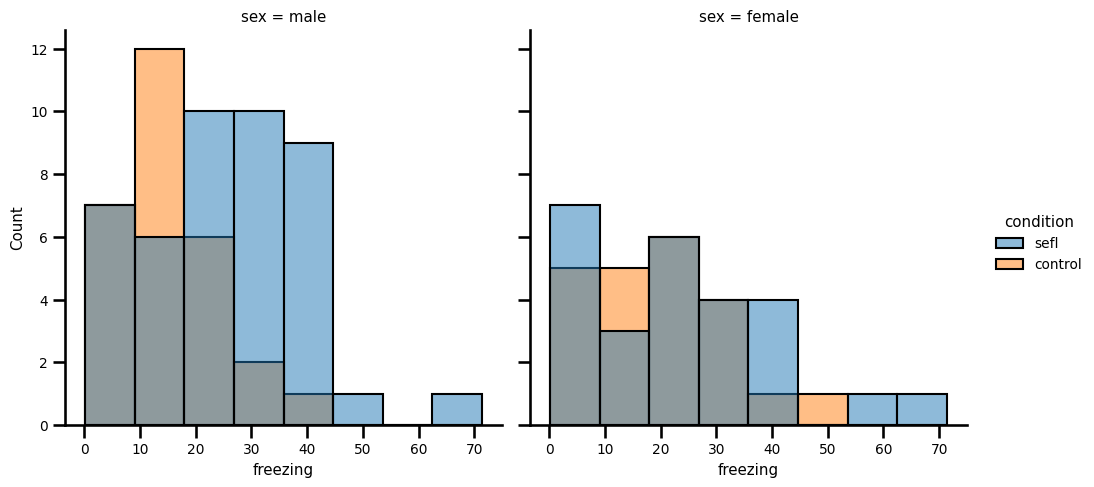

In [7]:
recall5 = mice_df[mice_df['day']== 'recall5']
recall5
d = sns.displot(recall5, x="freezing", hue="condition", bins=8)
d.set(title='Distribution of Freezing%')
d2 = sns.displot(recall5, x="freezing", col="sex",
                 hue="condition", bins=8)

In [8]:
# new_inx = ['day']
wide_df = mice_df.pivot(index=['cohort_id', 'sex',
                                         'condition'],columns='day',
                                  values='freezing')

wide_df.head()
corr = wide_df.groupby('condition').corr()
corr.min()

day
recall1   -0.001227
recall2    0.062141
recall3    0.061836
recall4    0.198211
recall5   -0.069547
sefla     -0.069547
seflb     -0.001227
dtype: float64

In [9]:
corr_ctrl = corr.iloc[corr.index.get_level_values('condition')=='control']
corr_sefl = corr.iloc[corr.index.get_level_values('condition')=='sefl']

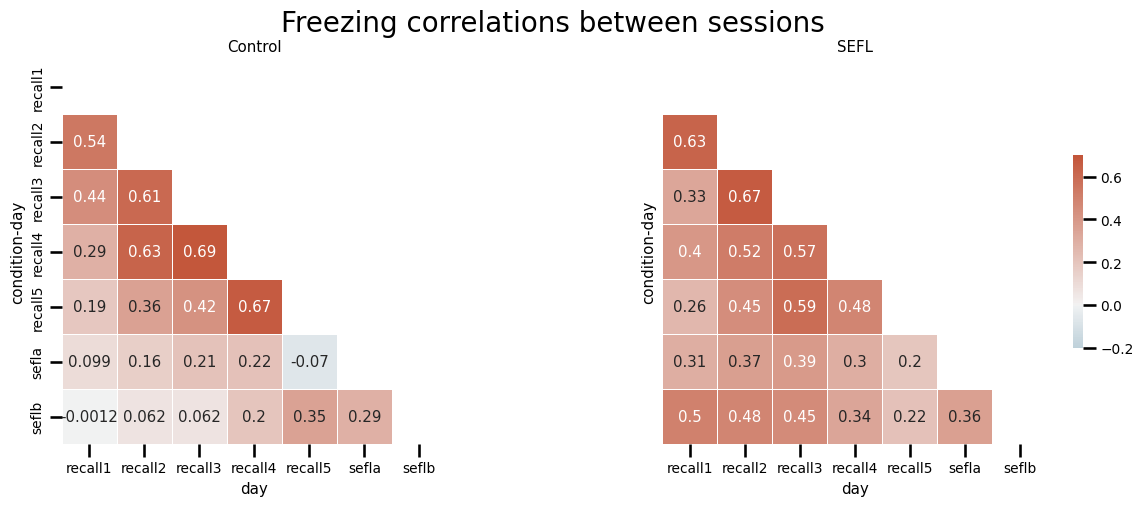

In [10]:
f, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

mask1 = np.zeros_like(corr_ctrl)
mask2 = np.zeros_like(corr_sefl)
mask1[np.triu_indices_from(mask1)] = True
mask2[np.triu_indices_from(mask2)] = True

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_ctrl, cmap=cmap, center=0, square=True, linewidths=.5,
            annot=True, cbar_kws={"shrink": .5}, ax=ax[0], mask=mask1,
            vmax=.7, vmin=-.2, cbar=False, yticklabels= ['recall1',
                                                         'recall2',
                                                         'recall3',
                                                         'recall4',
                                                         'recall5',
                                                         'sefla',
                                                         'seflb'],
            )
ax[0].set_title('Control')
sns.heatmap(corr_sefl, cmap=cmap, center=0, square=True, linewidths=.5,
            annot=True, cbar_kws={"shrink": .5}, ax=ax[1], mask=mask2,
            vmax=.7, vmin=-.2, yticklabels=False)
ax[1].set_title('SEFL')
f.suptitle('Freezing correlations between sessions', fontsize=20)
f.savefig(save_dir.joinpath(f"Freezing_corr_map_SEFL_ctrl_{datetime.now()}.png"),
          transparent=True, dpi=300, bbox_inches='tight')

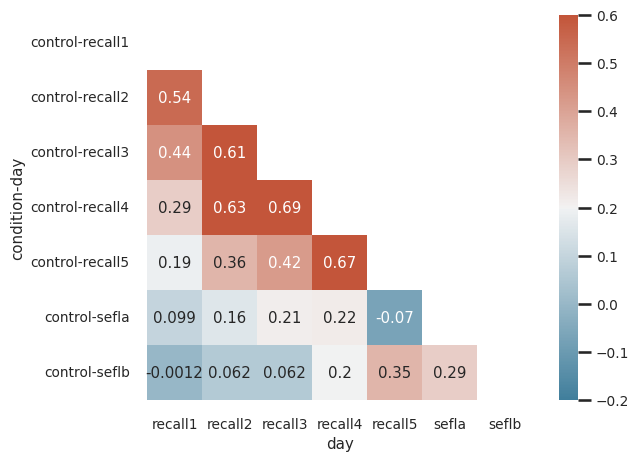

In [11]:
corr = corr_ctrl
mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)
with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(7, 5))

    ax = sns.heatmap(corr, mask=mask, vmax=.6, vmin=-.2,
                     square=True, annot=True,
                     cmap=cmap)